# Graph Coloring with QAOA using PyQuil and Grove

We are going to color a graph using the near-term algorithm QAOA. The canonical example of QAOA was to solve a MaxCut problem, but graph coloring can be seen as a generalization of MaxCut, which is really graph coloring with only k = 2 colors

## Sample problem: Graph with n = 4 nodes and e = 5 edges, k = 3 colors

First let's make some imports:

In [1]:
# pyquil and grove imports
from grove.pyqaoa.qaoa import QAOA
from pyquil.api import QVMConnection, get_qc, WavefunctionSimulator
from pyquil.paulis import PauliTerm, PauliSum
from pyquil import Program
from pyquil.gates import CZ, H, RY, CNOT, X


# useful additional packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### Generate a graph

Un-colored graph with 4 nodes, 5 edges, 3 colors:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


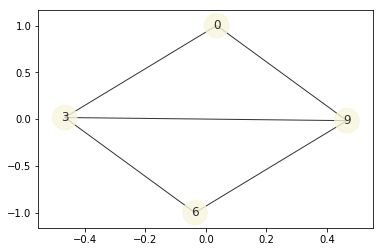

In [2]:
# generate graph, specify nodes and edges
G = nx.Graph()
edges = [(0, 3), (3, 6), (6, 9), (3, 9), (0, 9)]
nodes = [0, 3, 6, 9]

G.add_nodes_from(nodes)
G.add_edges_from(edges)



# Let's draw this thing
colors = ['beige' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

### Hamiltonians

To use QAOA, we need to consider two Hamiltonians:
* the Hamiltonian that best describes the cost function of our problem (cost Hamiltonian)
* and the Hamiltonian whose eigenstates span the solution space (mixer Hamiltonian)

Luckily for us, the cost Hamiltonian for graph coloring is the same as that for MaxCut:

$$H_{cost} = \sum_{i, j} \frac{1}{2}(\mathbb{1} - \sigma^z_i \sigma^z_j)$$

The mixer Hamiltonian must span the solution space, i.e. only those states that make any physical sense. If we allow $k=3$ qubits per node, and accept only W-states as solutions (100, 010, 001), then we can use the following mixer Hamiltonian:

$$H_{mixer} = \sum_{v, c, c'}\sigma^x_{v, c} \sigma^x_{v,c'} + \sigma^y_{v, c} \sigma^y_{v, c'}$$

Let's just create these Hamiltonians:

In [3]:
# define hamiltonians
def graph_coloring_cost_ham(graph, colors):
    cost_operators = []
    for k in range(len(colors)):
        for i, j in graph.edges():
            cost_operators.append(PauliTerm("Z", i + k, 0.5)*PauliTerm("Z", j + k) + PauliTerm("I", 0, -0.5))
    return cost_operators

def graph_coloring_mixer_ham(graph, colors):
    mixer_operators = []
    for k in range(0, len(graph.nodes())*len(colors), len(colors)):
        for i, j in colors:
            mixer_operators.append(PauliTerm("X", i + k, -1.0)*PauliTerm("X", j + k) + PauliTerm("Y", i + k)*PauliTerm("Y", j + k, -1.0))
    return mixer_operators

# above, note we've switched the sign of the Hamiltonians from those in the above equations
# this is because we use a classical minimizer, but we are actually trying to maximize the cost function


# instantiate mixer and cost
k = 3 # number of colors
colors = []
import itertools
for u, v in itertools.combinations(list(range(k)), 2):
    colors.append((u, v))
cost = graph_coloring_cost_ham(G, colors)
mixer = graph_coloring_mixer_ham(G, colors)


print('Mixer Hamiltonian: ∑ XX + YY')
for operator in mixer:
    print(operator)
print('\n')
print('Cost Hamiltonian: ∑ 1/2(I - ZZ)')
for operator in cost:
    print(operator)

Mixer Hamiltonian: ∑ XX + YY
(-1+0j)*X0*X1 + (-1+0j)*Y0*Y1
(-1+0j)*X1*X2 + (-1+0j)*Y1*Y2
(-1+0j)*X2*X0 + (-1+0j)*Y2*Y0
(-1+0j)*X3*X4 + (-1+0j)*Y3*Y4
(-1+0j)*X4*X5 + (-1+0j)*Y4*Y5
(-1+0j)*X5*X3 + (-1+0j)*Y5*Y3
(-1+0j)*X6*X7 + (-1+0j)*Y6*Y7
(-1+0j)*X7*X8 + (-1+0j)*Y7*Y8
(-1+0j)*X8*X6 + (-1+0j)*Y8*Y6
(-1+0j)*X9*X10 + (-1+0j)*Y9*Y10
(-1+0j)*X10*X11 + (-1+0j)*Y10*Y11
(-1+0j)*X11*X9 + (-1+0j)*Y11*Y9


Cost Hamiltonian: ∑ 1/2(I - ZZ)
(0.5+0j)*Z0*Z3 + (-0.5+0j)*I
(0.5+0j)*Z0*Z9 + (-0.5+0j)*I
(0.5+0j)*Z3*Z6 + (-0.5+0j)*I
(0.5+0j)*Z3*Z9 + (-0.5+0j)*I
(0.5+0j)*Z6*Z9 + (-0.5+0j)*I
(0.5+0j)*Z1*Z4 + (-0.5+0j)*I
(0.5+0j)*Z1*Z10 + (-0.5+0j)*I
(0.5+0j)*Z4*Z7 + (-0.5+0j)*I
(0.5+0j)*Z4*Z10 + (-0.5+0j)*I
(0.5+0j)*Z7*Z10 + (-0.5+0j)*I
(0.5+0j)*Z2*Z5 + (-0.5+0j)*I
(0.5+0j)*Z2*Z11 + (-0.5+0j)*I
(0.5+0j)*Z5*Z8 + (-0.5+0j)*I
(0.5+0j)*Z5*Z11 + (-0.5+0j)*I
(0.5+0j)*Z8*Z11 + (-0.5+0j)*I


### Initial state

We must feed an inital reference state to QAOA that we will evolve to the ground state of the cost Hamiltonian. This initial state should ideally span the solution space, i.e. all physically relevant states. For our purposes, these would be the W-States.

First let's make functions that can create W-States:

In [4]:
# Define a F_gate

def F_gate(prog, i, j, n, k):
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    prog += [RY(-theta, j),
             CZ(i, j),
             RY(theta, j)]
    
# Generate W-states    
def wstategenerate(prog, q0, q1, q2):
    prog += X(q2)
    F_gate(prog, q2, q1, 3, 1)
    F_gate(prog, q1, q0, 3, 2)
    prog += CNOT(q1, q2)
    prog += CNOT(q0, q1)
    return prog


Now let's initialize W-states to feed our QAOA for the above graph:

In [5]:
# initialize state
initial_state = wstategenerate(Program(), 0, 1, 2) + wstategenerate(Program(), 3, 4, 5) + wstategenerate(Program(), 6, 7, 8) + wstategenerate(Program(), 9, 10, 11)

Quick test to make sure we are actually making W-states...

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


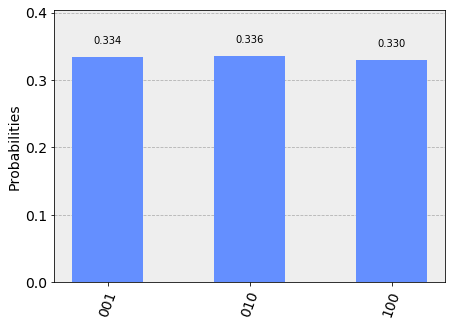

In [6]:
# qvm instantiation to run W-state generation
qvm_connection = QVMConnection()

# makes it easier to count up results
from collections import Counter

# get results with their counts
tests = qvm_connection.run_and_measure(initial_state, [9, 10, 11], trials=1000)
tests = [tuple(test) for test in tests]
tests_counter_tuples = Counter(tests)
most_common = tests_counter_tuples.most_common()

tests_counter = {}

for element in most_common:
    result = element[0]
    total = element[1]
    result_string = ''
    for bit in result:
        result_string += str(bit)
    tests_counter[result_string] = total

tests_counter

# import for histogram plotting
from qiskit.tools.visualization import plot_histogram

# plot the results with their counts
plot_histogram(tests_counter)

We only see the results 001, 010, and 100, so we're good!

### Use QAOA with specified parameters

Now let's instantiate QAOA with the specified cost, mixer, and number of steps:

In [7]:
# number of Trotterized steps for QAOA (I recommend two)
p = 2


# set initial beta and gamma angle values (you could try others, I find these work well)
initial_beta = [0, np.pi]
initial_gamma = [0, np.pi*2]


# arguments for the classical optimizer
minimizer_kwargs = {'method': 'Nelder-Mead',
                            'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2,
                                        'disp': False}}


# list of qubit ids on instantiated qvm we'll be using
num_qubits = len(colors)*len(G.nodes())
qubit_ids = list(range(num_qubits))


# instantiation of QAOA with requisite parameters
QAOA_inst = QAOA(qvm_connection, qubit_ids, 
                     steps=p, 
                     cost_ham=cost,
                     ref_ham=mixer, 
                     driver_ref=initial_state,
                     init_betas=initial_beta,
                     init_gammas=initial_gamma,
                     minimizer_kwargs=minimizer_kwargs)

Solve for betas and gammas. All of the optimization happens here:

In [8]:
betas, gammas = QAOA_inst.get_angles()
print("Values of betas:", betas)
print("Values of gammas:", gammas)
print("And the most common measurement is... ")
most_common_result, _ = QAOA_inst.get_string(betas, gammas)
print(most_common_result)

                     models will be ineffective
Values of betas: [-3.92793078e-04  3.25023485e+00]
Values of gammas: [-1.35018800e-04  6.65965129e+00]
And the most common measurement is... 
(0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0)


### Reconstruct Program

Now that we've used QAOA to solve for the optimal beta and gamma values, we can reconstruct the ground state solution by initializing a new `Program()` object with these values

In [9]:
angles = np.hstack((betas, gammas))
# We take a template for quil program
param_prog = QAOA_inst.get_parameterized_program()
# We initialize this program with the angles we have found
prog = param_prog(angles)

### Run and Measure Program

Now that we've reconstructed the program with the proper angles, we can run and measure this program on the QVM many times to get statistics on the outcome 

In [10]:
# Here we connect to the Forest API and run our program there.
# We do that 10000 times and after each one we measure the output.
measurements = qvm_connection.run_and_measure(prog, qubit_ids, trials=10000)

Just reformatting results into a dictionary...

In [11]:
# This is just a hack - we can't use Counter on a list of lists but we can on a list of tuples.
measurements = [tuple(measurement) for measurement in measurements]
measurements_counter = Counter(measurements)
# This line gives us the results in the diminishing order
most_common = measurements_counter.most_common()
most_common

measurements_counter = {}

for element in most_common:
    result = element[0]
    total = element[1]
    result_string = ''
    for bit in result:
        result_string += str(bit)
    measurements_counter[result_string] = total

measurements_counter

{'010001010100': 578,
 '010100010001': 543,
 '001010001100': 529,
 '100010100001': 488,
 '100001100010': 488,
 '001100001010': 478,
 '001010100010': 244,
 '010010100001': 236,
 '001100010010': 234,
 '100010010001': 232,
 '010010001100': 224,
 '001010010100': 224,
 '100010001010': 224,
 '100001010010': 216,
 '010001100010': 216,
 '100001010100': 203,
 '010100001010': 188,
 '010100001100': 183,
 '100100010001': 177,
 '010001100100': 176,
 '010100100001': 172,
 '100100001010': 170,
 '001010100100': 164,
 '010001001100': 163,
 '010001100001': 160,
 '100001010001': 160,
 '001100010100': 159,
 '001100100010': 159,
 '100010001100': 158,
 '001001100010': 148,
 '100010100010': 140,
 '100010001001': 137,
 '010100001001': 136,
 '001001010100': 133,
 '001010001010': 133,
 '001100010001': 132,
 '100001001010': 129,
 '001010100001': 127,
 '010100010100': 108,
 '100001100001': 78,
 '001100001100': 74,
 '010001010001': 74,
 '010100100010': 63,
 '100010010100': 49,
 '010010010010': 44,
 '100100010010':

And now reformat bit strings into colors...

In [12]:
# Reformat these bit strings into colors
# Choose which state refers to red ('r'), blue ('b') or green ('g')

colors_totals = {}
for bitstring, total in measurements_counter.items():
    node_0 = bitstring[0:3]
    node_1 = bitstring[3:6]
    node_2 = bitstring[6:9]
    node_3 = bitstring[9:12]
    
    nodes_list = [node_0, node_1, node_2, node_3]
    node_colors_string = ''
    for node in nodes_list:
        if node == '100':
            node = 'r'
        elif node == '010':
            node = 'b'
        elif node == '001':
            node = 'g'
        else:
            raise Exception('Invalid!')
            
        node_colors_string += node
    
    colors_totals[node_colors_string] = total
        
            
print(colors_totals)   

{'bgbr': 578, 'brbg': 543, 'gbgr': 529, 'rbrg': 488, 'rgrb': 488, 'grgb': 478, 'gbrb': 244, 'bbrg': 236, 'grbb': 234, 'rbbg': 232, 'bbgr': 224, 'gbbr': 224, 'rbgb': 224, 'rgbb': 216, 'bgrb': 216, 'rgbr': 203, 'brgb': 188, 'brgr': 183, 'rrbg': 177, 'bgrr': 176, 'brrg': 172, 'rrgb': 170, 'gbrr': 164, 'bggr': 163, 'bgrg': 160, 'rgbg': 160, 'grbr': 159, 'grrb': 159, 'rbgr': 158, 'ggrb': 148, 'rbrb': 140, 'rbgg': 137, 'brgg': 136, 'ggbr': 133, 'gbgb': 133, 'grbg': 132, 'rggb': 129, 'gbrg': 127, 'brbr': 108, 'rgrg': 78, 'grgr': 74, 'bgbg': 74, 'brrb': 63, 'rbbr': 49, 'bbbb': 44, 'rrbb': 42, 'bbrr': 42, 'bggb': 41, 'rrrr': 41, 'gggg': 37, 'brbb': 35, 'bbbr': 32, 'bbgg': 31, 'ggrr': 31, 'gbbg': 30, 'rggr': 29, 'ggbb': 27, 'ggbg': 26, 'grrg': 24, 'rrgg': 24, 'rggg': 23, 'bggg': 23, 'rrbr': 23, 'rrgr': 19, 'ggrg': 19, 'rrrb': 18, 'bbbg': 15, 'grrr': 15, 'bgbb': 15, 'rbrr': 13, 'gbbb': 12, 'brrr': 12, 'rbbb': 9, 'grgg': 9, 'bbgb': 8, 'bbrb': 7, 'gggr': 4, 'rrrg': 4, 'gggb': 3, 'gbgg': 3, 'rgrr': 

### Visualize results

First let's plot the results as a histogram. There are tons of possible solutions ($k^n = 3^4 = 81$), but we should expect that 6 of them occur most often, so we're looking for 6 larger peaks. This is because for this particular graph and number of colors, there are 6 colorings that maximize the cost function.

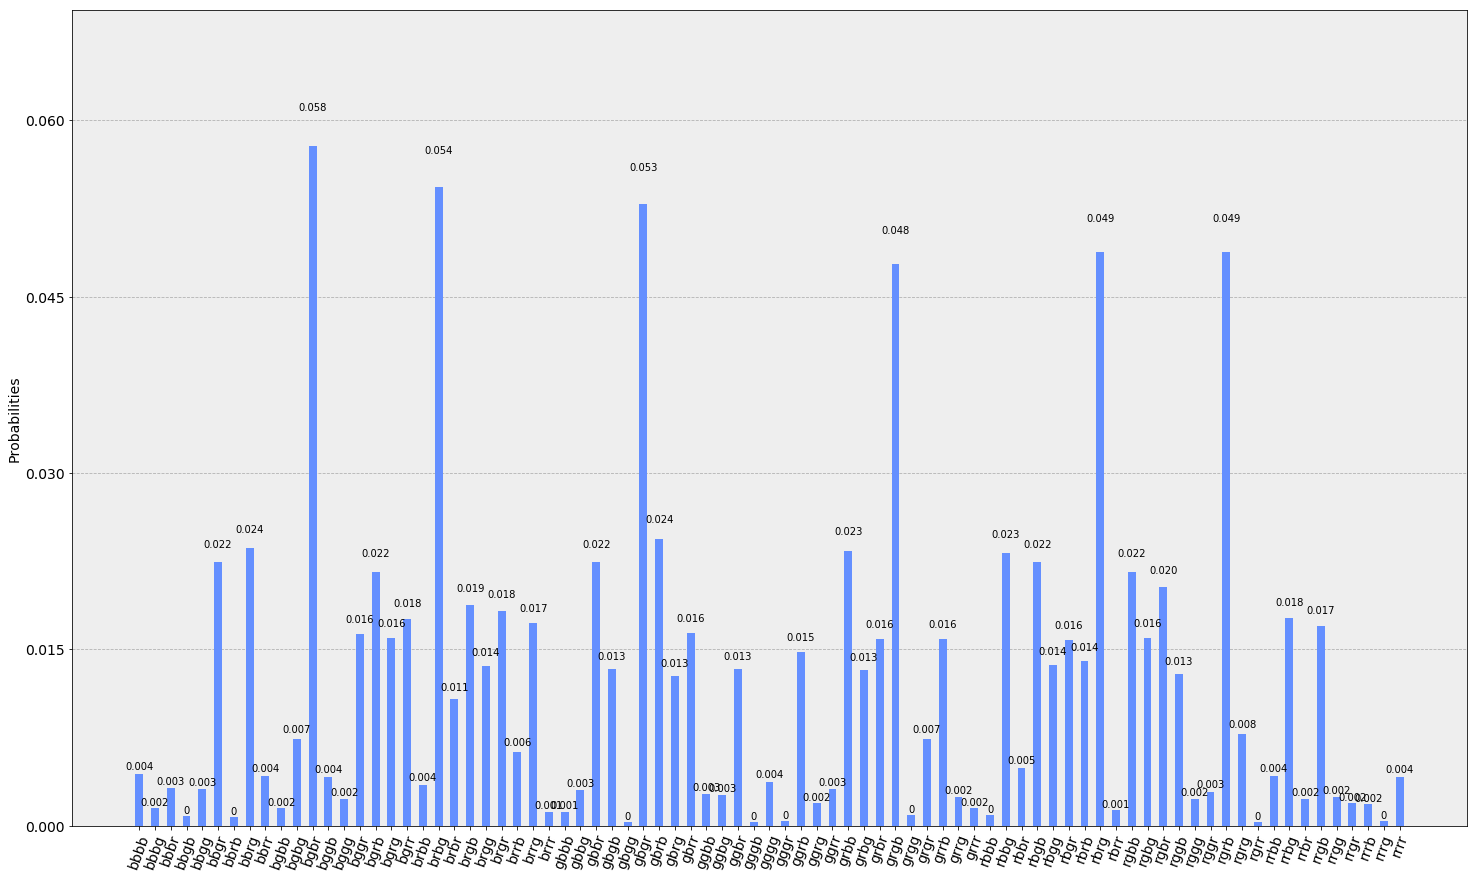

In [13]:
plot_histogram(colors_totals, figsize=(25, 15))

Finally, let's color the graph using these solutions. The colors and their totals have already been ordered from most results to least, so we should expect that the first 6 (i.e. 0-5) colorings maximize the number of non-adjacent colors on the graph

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


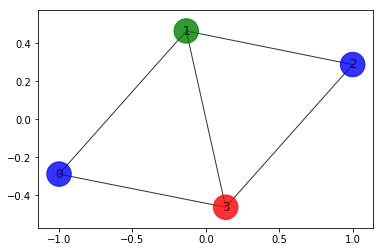

In [14]:
# make graph
Graph = nx.Graph()
edges = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)]
nodes = range(4)

Graph.add_nodes_from(nodes)
Graph.add_edges_from(edges)

# Let's draw this thing




# can increment the index at the end to get the max value and the next max totals
# i.e. try [0], [1], ... , [5]
colors = list(colors_totals.keys())[0]



# draw colored graph
pos = nx.spring_layout(Graph)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(Graph, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

<br>